Study of the latent space dimension

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random


from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model


In [ ]:
#initial parameters
t = np.arange(1, 101, 1)
n = 20000 #number of samples
number_train_data= int(n*0.9*0.7)
number_val_data= int(n*0.9*0.3)
number_test_data = int(n*0.1)

In [ ]:
#definition of empty matrices
period = [0 for _ in range(n)]
amplitud = [0 for _ in range(n)]
phase = [0 for _ in range(n)]
x = [[0 for _ in range(100)] for _ in range(n)] #n files 100 columnes
x = np.array(x).astype("float32")
train_data = np.empty(shape=(number_train_data, 100), dtype='object')
val_data = np.empty(shape=(number_val_data, 100), dtype='object')
test_data = np.empty(shape=(number_test_data, 100), dtype='object')
input_data=[]

In [ ]:
#creation of input data
for i in range(n):
  amplitud[i] = np.random.uniform(1, 10)
  period[i] = np.random.uniform(25,50)
  phase[i] = np.random.uniform(0, 360)

for i in range(n):
  for j in range(100):
    x[i,j] = amplitud[i] * np.sin(2. * np.pi * (t[j] / period[i] + phase[i] / 360.))

for i in range(number_train_data):
  for j in range(100):
    train_data[i][j]=x[i,j]

for i in range(number_train_data, number_train_data+number_val_data):
  for j in range(100):
    val_data[i-number_train_data][j]=x[i,j]

for i in range(number_train_data+number_val_data, n):
  for j in range(100):
    test_data[i-number_train_data-number_val_data][j]=x[i,j]

train_data = np.array(train_data).astype('float32')
val_data = np.array(val_data).astype('float32')
test_data = np.array(test_data).astype('float32')

train_data = train_data[~np.isnan(train_data)]
val_data = val_data[~np.isnan(val_data)]
test_data = test_data[~np.isnan(test_data)]

train_data = train_data.reshape((len(train_data)//100,100*1)).astype('float32')
val_data = val_data.reshape((len(val_data)//100,100*1)).astype('float32')
test_data = test_data.reshape((len(test_data)//100,100*1)).astype('float32')

input_data=np.concatenate((train_data,val_data,test_data), axis=None).astype('float32')

train_data = (train_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))
val_data = (val_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))
test_data = (test_data-np.min(input_data))/(np.max(input_data)-np.min(input_data))

train_data = train_data.reshape((-1, 1, 100))
test_data = test_data.reshape((-1, 1, 100))
val_data = val_data.reshape((-1, 1, 100))

train_data = tf.stack(train_data)
val_data= tf.stack(val_data)
test_data= tf.stack(test_data)

In [ ]:
latent_dims = np.arange(1,20, 1)
lossesvecval = []
for k in range(len(latent_dims)):
  class Autoencoder(Model):
      def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dims[k]
        self.encoder = tf.keras.Sequential([
          layers.Dense(100, activation='linear'),
          layers.Dense(100, activation='relu'),
          layers.Dense(80, activation='relu'),
          layers.Dense(latent_dims[k], activation='relu'),
          ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(80, activation='relu'),
            layers.Dense(100, activation='relu'),
            layers.Dense(100, activation='linear'),
          ])

      def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

  autoencoder = Autoencoder(latent_dim=latent_dims[k])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
  autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())
  history = autoencoder.fit(train_data, train_data,
                epochs=60,
                shuffle=True,
                batch_size=128,
                validation_data=(val_data, val_data), callbacks=[early_stopping])

  last_epoch_loss2 = history.history['val_loss'][-1]
  lossesvecval.append(last_epoch_loss2)


Text(0, 0.5, 'Val loss')

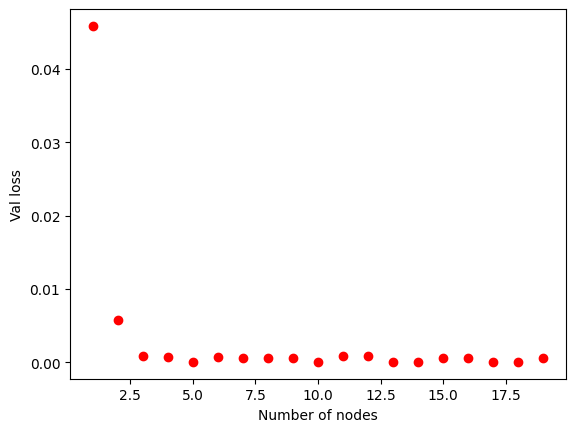

In [ ]:
plt.scatter(latent_dims, lossesvecval, color='red')
plt.xlabel('Number of nodes')
plt.ylabel('Val loss')

In [ ]:
lossesvecval

[0.045844968408346176,
 0.005749780219048262,
 0.0008989294292405248,
 0.0007516896002925932,
 7.442966307280585e-05,
 0.0007667025256597032,
 0.0006534150736325933,
 0.0005556880226425932,
 0.0006406403458325933,
 6.332472070500585e-05,
 0.0008574508158425932,
 0.0008822663657258932,
 5.6411525419695856e-05,
 6.333114172720585e-05,
 0.0006441942789773333,
 0.0005305962116385933,
 5.338264717404585e-05,
 6.349392743027586e-05,
 0.0005517063246391932]